<a href="https://colab.research.google.com/github/redlani/RecipeGenerator/blob/main/RecipeMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note to the Reader
This notebook was originally created following the tutorial outlined for [Recipe Generation using RNN](https://towardsdatascience.com/generating-cooking-recipes-using-tensorflow-and-lstm-recurrent-neural-network-a7bf242acad3). It has since been modified to include needed changes and comparison across other model types.

# Data Prep & Cleaning Before Model Building

## Import Dependencies


In [1]:
# !export PATH="/Users/kailaniredding/anaconda3/bin:$PATH"
# !conda init zsh
# !conda activate tf
# !python3 --version

In [2]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
import time
import pathlib
import os
import json
import zipfile
import nltk

In [3]:
# for the hosted runtime
import tensorflow as tf
from google.colab import files
from google.colab import drive

## Download Data
Also available here:
https://eightportions.com/datasets/Recipes/

In [4]:
# mount drive to get dataset and save model files automatically
drive_path = "/content/drive"
drive_mounted = os.path.exists(drive_path)

if drive_mounted:
  print("Drive already mounted and ready")
else:
  drive.mount('/content/drive')

Drive already mounted and ready


In [5]:
# use data available in the google drive
data_path = "/content/recipes_raw_nosource_ar.json"
unzipped = os.path.exists(data_path)

if unzipped:
  print("Data already unzipped and ready... see list of files below")
  # check to see the loaded file sets
  !ls -la /content
else:
  !unzip /content/drive/MyDrive/deep_learning/dataset/recipes_raw.zip
  !ls -la /content

Archive:  /content/drive/MyDrive/deep_learning/dataset/recipes_raw.zip
  inflating: recipes_raw_nosource_ar.json  
  inflating: recipes_raw_nosource_epi.json  
  inflating: recipes_raw_nosource_fn.json  
  inflating: LICENSE                 
total 199872
drwxr-xr-x 1 root root     4096 Apr 17 00:52 .
drwxr-xr-x 1 root root     4096 Apr 17 00:49 ..
drwxr-xr-x 4 root root     4096 Apr 13 13:29 .config
drwx------ 6 root root     4096 Apr 17 00:52 drive
-rw-rw-r-- 1 root root    20437 Feb 12  2018 LICENSE
-rw-rw-r-- 1 root root 49784325 Mar 23  2018 recipes_raw_nosource_ar.json
-rw-rw-r-- 1 root root 61133971 Mar 23  2018 recipes_raw_nosource_epi.json
-rw-rw-r-- 1 root root 93702755 Mar 23  2018 recipes_raw_nosource_fn.json
drwxr-xr-x 1 root root     4096 Apr 13 13:30 sample_data


In [6]:
def load_dataset(silent=False):
    cache_dir= '/content'
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

In [7]:
# load and preview
dataset_raw = load_dataset()
print('Total number of raw examples: ', len(dataset_raw))

/content/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicken brea


## Pre-Process the Dataset

In [8]:
# filter out recipes which don't have either title or ingredients or instructions.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [9]:
# compare before/after pre-processing
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of invalide recipes 2226


### Converting recipe objects into string

In [10]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [11]:
# converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [12]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [13]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [14]:
print(dataset_stringified[50000])

📗 Herbed Bean Ragoût 

🥕

• 6 ounces haricots verts (French thin green beans), trimmed and halved crosswise
• 1 (1-pound) bag frozen edamame (soybeans in the pod) or 1 1/4 cups frozen shelled edamame, not thawed
• 2/3 cup finely chopped onion
• 2 garlic cloves, minced
• 1 Turkish bay leaf or 1/2 California bay leaf
• 2 (3-inch) fresh rosemary sprigs
• 1/2 teaspoon salt
• 1/4 teaspoon black pepper
• 1 tablespoon olive oil
• 1 medium carrot, cut into 1/8-inch dice
• 1 medium celery rib, cut into 1/8-inch dice
• 1 (15- to 16-ounces) can small white beans, rinsed and drained
• 1 1/2 cups chicken stock or low-sodium broth
• 2 tablespoons unsalted butter
• 2 tablespoons finely chopped fresh flat-leaf parsley
• 1 tablespoon finely chopped fresh chervil (optional)
• Garnish: fresh chervil sprigs

📝

▪︎ Cook haricots verts in a large pot of boiling salted water until just tender, 3 to 4 minutes. Transfer with a slotted spoon to a bowl of ice and cold water, then drain. Add edamame to boiling wa

### Filter out large recipes
We need a hard-coded sequence length limit before feeding recipe sequences into RNN

In [15]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

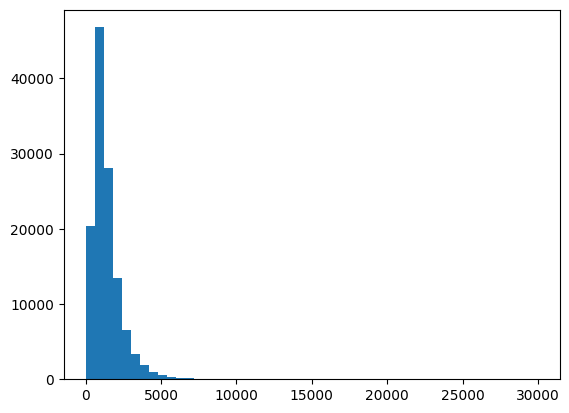

In [16]:
plt.hist(recipes_lengths, bins=50)
plt.show()

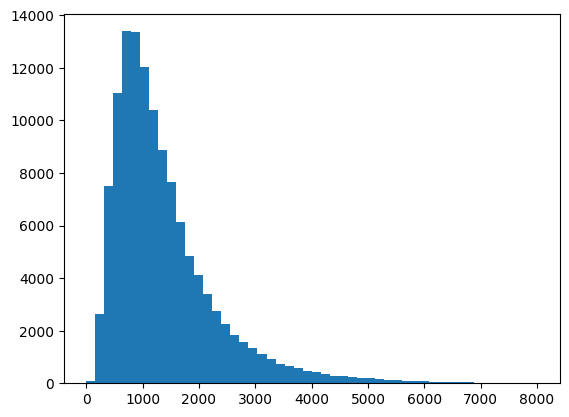

In [17]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [18]:
# looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000

In [19]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [20]:
# compare before/after filtering
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of etiminated recipes:  22726


### Summarizing Dataset Parameters

In [21]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100212


# Model 1: RNN LSTM Model for Recipe Generation

## Create Vocab

In [22]:
# indicator of the end of the recipe.
STOP_SIGN = '␣'

In [23]:
rnn_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [24]:
# stop word is not a part of recipes, but tokenizer must know about it as well.
rnn_tokenizer.fit_on_texts([STOP_SIGN])

In [25]:
rnn_tokenizer.fit_on_texts(dataset_filtered)

In [26]:
rnn_tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100213,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 100212, " ": 17527888, "S": 270259, "l": 3815150, "o": 5987496, "w": 964459, "C": 222831, "k": 890982, "e": 9296022, "r": 4760887, "h": 2922100, "i": 4911812, "c": 2883507, "n": 5304396, "a": 6067157, "d": 3099679, "D": 63999, "u": 2717050, "m": 1794411, "p": 2679164, "g": 1698670, "s": 4704222, "\\n": 1955281, "\\ud83e\\udd55": 100212, "\\u2022": 922813, "4": 232607, ",": 1130487, "b": 1394803, "t": 5997722, "v": 746785, "2": 493933, "(": 144985, "1": 853931, "0": 145119, ".": 1052548, "7": 31098, "5": 154071, ")": 144977, "f": 1042981, "y": 666553, "\\ud83d\\udcdd": 100212, "\\u25aa": 331058, "\\ufe0e": 331058, "P": 200597, "6": 51398, "H": 43936, "A": 134274, "3": 213519, "R": 101253, "x": 201286, "/": 345257, "I": 81591, "L": 46138, "8": 55352, "9": 17697, "B": 123813, "M": 78684, "F": 104359, "j": 1

In [27]:
# adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(rnn_tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


In [28]:
print(rnn_tokenizer.index_word[5])
print(rnn_tokenizer.index_word[20])

o
,


In [29]:
rnn_tokenizer.word_index['r']

8

In [30]:
# test proper conversion from text to indices.
# this is needed for debugging a demo app.
rnn_tokenizer.texts_to_sequences(['📗 yes'])

[[51, 1, 28, 2, 9]]

### Vectorize Recipe Texts

In [31]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = rnn_tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [32]:
dataset_vectorized = rnn_tokenizer.texts_to_sequences(dataset_filtered)

In [33]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 100212


In [34]:
print(dataset_vectorized[0][:10], '...')

[51, 1, 33, 10, 5, 23, 1, 35, 5, 5] ...


In [35]:
max_index_example = np.max(dataset_vectorized)

print('max_index_example: ', max_index_example)

max_index_example:  [51, 1, 97, 26, 1, 39, 2, 3, 1, 33, 3, 10, 3, 11, 1, 55, 5, 9, 4, 1, 50, 2, 57, 14, 2, 9, 4, 2, 11, 83, 16, 16, 52, 16, 16, 24, 1, 29, 1, 42, 26, 62, 1, 5, 14, 6, 13, 2, 43, 1, 15, 3, 13, 25, 3, 18, 2, 9, 1, 22, 8, 5, 46, 2, 6, 1, 15, 2, 4, 7, 4, 2, 1, 15, 2, 3, 9, 1, 16, 24, 1, 62, 1, 5, 14, 6, 13, 2, 9, 1, 9, 17, 5, 25, 2, 36, 22, 10, 3, 27, 5, 8, 2, 11, 1, 3, 10, 17, 5, 6, 11, 9, 20, 1, 22, 7, 6, 2, 10, 28, 1, 13, 12, 5, 15, 15, 2, 11, 1, 16, 24, 1, 26, 1, 5, 6, 7, 5, 6, 20, 1, 22, 7, 6, 2, 10, 28, 1, 13, 12, 5, 15, 15, 2, 11, 1, 16, 24, 1, 26, 1, 13, 14, 15, 1, 17, 3, 28, 5, 6, 6, 3, 7, 9, 2, 20, 1, 5, 8, 1, 17, 5, 8, 2, 1, 4, 5, 1, 4, 3, 9, 4, 2, 1, 16, 24, 1, 18, 8, 5, 14, 6, 11, 1, 19, 10, 3, 13, 25, 1, 15, 2, 15, 15, 2, 8, 1, 4, 5, 1, 4, 3, 9, 4, 2, 1, 16, 16, 53, 16, 16, 31, 32, 1, 39, 10, 3, 13, 2, 1, 22, 8, 5, 46, 2, 6, 1, 15, 2, 3, 9, 1, 7, 6, 1, 3, 1, 13, 5, 10, 3, 6, 11, 2, 8, 56, 1, 8, 7, 6, 9, 2, 1, 14, 6, 11, 2, 8, 1, 13, 5, 10, 11, 1, 23, 3, 4, 2, 

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [36]:
recipe_sequence_to_string(dataset_vectorized[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



#### Add padding to sequences
Keep all recipes the same length for training

In [37]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [38]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=rnn_tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [39]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=rnn_tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [40]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [41]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [42]:
max_index_example = np.max(dataset_vectorized_padded)

print('max_index_example: ', max_index_example)

max_index_example:  175


## Create TensorFlow Dataset

In [43]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


In [44]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

### Split on `input` and `target`

In [45]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [46]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [47]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = rnn_tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = rnn_tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


In [48]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(rnn_tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(rnn_tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 33 ('S')
Step  3
  input: 33 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 5 ('o')
Step  5
  input: 5 ('o')
  expected output: 23 ('w')
Step  6
  input: 23 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 35 ('C')
Step  8
  input: 35 ('C')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 5 ('o')
Step 10
  input: 5 ('o')
  expected output: 25 ('k')


In [49]:
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [50]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100212
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


In [51]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

In [52]:
dataset_train = dataset_targeted \
  .shuffle(SHUFFLE_BUFFER_SIZE) \
  .batch(BATCH_SIZE, drop_remainder=True) \
  .repeat()

In [53]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  61 ... 165 165 165]
 [ 51   1  50 ... 165 165 165]
 [ 51   1  45 ... 165 165 165]
 ...
 [ 51   1  55 ... 165 165 165]
 [ 51   1  48 ... 165 165 165]
 [ 51   1  84 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  61   8 ... 165 165 165]
 [  1  50   3 ... 165 165 165]
 [  1  45   2 ... 165 165 165]
 ...
 [  1  55   5 ... 165 165 165]
 [  1  48   3 ... 165 165 165]
 [  1  84  14 ... 165 165 165]], shape=(64, 2000), dtype=int32)


## Build the Model

In [54]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 123ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[0 4 9 1 5 4 9 5]
 [8 5 1 5 5 2 8 0]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.03598675 -0.02756232 -0.04683362 -0.01702428  0.02726119]
  [ 0.03959863  0.02530444 -0.03602891 -0.01854392  0.04122752]
  [-0.04543215  0.04568875 -0.04998151 -0.00595547  0.02941128]
  [-0.0382275   0.00954754 -0.01396258 -0.00196676  0.04980579]
  [-0.00545805 -0.01402915  0.01413004 -0.00154484 -0.01963386]
  [ 0.03959863  0.02530444 -0.03602891 -0.01854392  0.04122752]
  [-0.04543215  0.04568875 -0.04998151 -0.00595547  0.02941128]
  [-0.00545805 -0.01402915  0.01413004 -0.00154484 -0.01963386]]

 [[ 0.00704462 -0.01693541  0.01624518  0.04742715  0.01785913]
  [-0.00545805 -0.01402915  0.01413004 -0.00154484 -0.01963386]
  [-0.0382275   0.00954754 -0.01396258 -0.00196676  0.04980579]
  [-0.00545805 -0.01402915  0.01413004 -0.00154484 -0.01963386]
  [-0.00545805 -0.01402915  0.01413004

In [55]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [56]:
def build_rnn_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [57]:
model_1 = build_rnn_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           45056     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 176)           180400    
                                                                 
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


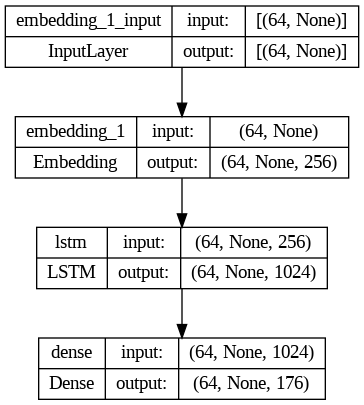

In [58]:
tf.keras.utils.plot_model(
    model_1,
    show_shapes=True,
    show_layer_names=True,
    to_file='model_1.png'
)

### Try the Model

In [59]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


In [60]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-3.0459568e-03 -1.3459628e-03 -1.4912693e-03 -1.1866433e-03
 -1.5094266e-03  3.9037263e-03  8.0332428e-04 -2.1332761e-03
 -8.0889184e-03 -6.2990235e-04  2.3365598e-03  9.5456082e-04
 -1.7582809e-03 -1.7961615e-03 -5.1765935e-05 -2.6958280e-03
 -1.9684150e-03 -2.7718197e-03 -3.0413270e-03  6.8605854e-04
  5.4408656e-03  9.9045792e-05 -5.4854769e-03  2.2680061e-04
  2.9594239e-03  5.5577524e-04  2.7334536e-03  1.1652261e-03
 -3.0941891e-03 -3.4844277e-03 -3.5169204e-03 -2.8024474e-04
 -2.2337763e-03  3.6506844e-03 -2.4445546e-03 -1.6678530e-03
  1.6300147e-03 -2.3389594e-03 -2.6135207e-03 -7.3827978e-04
 -4.9040848e-03  1.4488873e-03  6.2549533e-03  4.3564187e-03
 -3.9482010e-03 -1.7645187e-04 -3.4649144e-03  7.5102630e-03
 -3.1188556e-03 -2.0116884e-03  7.8914883e-03 -4.9479823e-03
  6.5978765e-03 -2.9853913e-03 -8.9608482e-04 -2.2274433e-03
  5.8159651e-04  4.5982182e-05  2.5283112e-03 -1.7064307e-03
 -4.2498657e-03  

In [61]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[0 2 2 2 2]], shape=(1, 5), dtype=int64)


In [62]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([2000, 1])

In [63]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [64]:
sampled_indices[:100]

array([ 99,  98,   8, 118,   4, 173, 147, 169, 154, 107,  88, 107, 160,
        16, 120, 149, 145,  29,  84, 117,  45,  84,  12,  13,  53,   4,
       165,  29, 100,  32, 117,  35,  37,  77,  70, 117, 154,  81, 114,
        56,  97, 124,  27,  71,  33, 100, 150, 160,  93,  17, 122, 129,
        41,  68, 164, 175,  52,  68,  90, 149, 100, 143, 126, 166, 153,
        35,  57,  40, 163, 129,  49,  80, 128,  89,  73,  16,  38, 150,
        11, 171,  88,  25,  37,  94,   9,  98, 144,  54,  98,  82,  22,
       141,  67,  46, 127,  24, 134, 159,  89,   3])

In [65]:
print('Input:\n', repr(''.join(rnn_tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(rnn_tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📗   O l d   F a s h i o n e d   C o c o n u t   C r e a m   P i e \n \n 🥕 \n \n •   1   c u p   s w e e'

Next char prediction:
 'í ½ r ê t € ‧ ơ ë $ ñ $ ư \n _ ⅛ ‱ 2 Z ü B Z h c 📝 t ␣ 2 = ︎ ü C 3 ° K ü ë Q û ; # � v 9 S = å ư ? m'


### Try the Model with Variable Input

In [66]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 176) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

## Train the Model

Attach an optimizer and a loss function

In [67]:
for input_example_batch_custom, target_example_batch_custom in dataset_train.take(1):
    random_input = np.zeros(shape=(BATCH_SIZE, 10))
    example_batch_predictions_custom = model_1(random_input)
    print('Prediction shape: ', example_batch_predictions_custom.shape, "# (batch_size, sequence_length, vocab_size)\n")
    print('Custom length input: ')
    print(random_input)

Prediction shape:  (64, 10, 176) # (batch_size, sequence_length, vocab_size)

Custom length input: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0

In [68]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.17861


In [69]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss,
    metrics=['accuracy']
)

### Configure Checkpoints

In [70]:
# Directory where the checkpoints will be saved.
checkpoint_dir = '/content/drive/MyDrive/deep_learning/rnn_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [71]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [72]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [73]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [74]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

### Configuring Callbacks

In [75]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [76]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

## Run the Training

In [77]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
EPOCHS_DELTA = 10
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = 1500

print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

Latest checkpoint was not found. Starting from epoch #0


INITIAL_EPOCH:    0
EPOCHS_DELTA:     10
EPOCHS:           10
STEPS_PER_EPOCH:  1500


In [82]:
# initialize before training, if needed
try: 
  print("History exists.")
  print(history_1)
except NameError:
  print("History cleared.")
  history_1 = {}

History exists.
{}


In [83]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

Epoch 1/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2535 - accuracy: 0.9199
Epoch 2/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2504 - accuracy: 0.9208
Epoch 3/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2477 - accuracy: 0.9216
Epoch 4/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2451 - accuracy: 0.9223
Epoch 5/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2431 - accuracy: 0.9229
Epoch 6/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2419 - accuracy: 0.9233
Epoch 7/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2396 - accuracy: 0.9239
Epoch 8/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2380 - accuracy: 0.9244
Epoch 9/10
1500/1500 [==============================] - 213s 142ms/step - loss: 0.2366 - accuracy: 0.9248
Epoch 10/10
1500/1500 [=======================

In [84]:
# model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
# model_1.save(model_name, save_format='h5')

model_1.save("/content/drive/MyDrive/deep_learning/rnn/rnn_recipe_generation")
download_latest_checkpoint(zip_only=True)

latest_checkpoint_path:  /content/drive/MyDrive/deep_learning/rnn_checkpoints/ckpt_10
latest_checkpoint_name:  ckpt_10
---

Checkpoint files:
  - ckpt_10.data-00000-of-00001
  - ckpt_10.index
---

Zipped to:  ckpt_10.zip


In [85]:
print(history_1)

{0: <keras.callbacks.History object at 0x7f253bb749a0>}


#### Visualize the Training Process

In [86]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

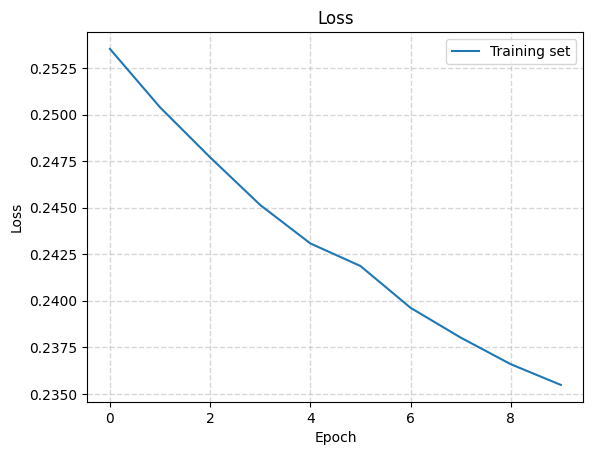

In [87]:
render_training_history(history_1)

## Benchmark with Metrics
Determine the baseline moving forward

## Save the LSTM Model

In [ ]:
# model_name = 'recipe_generation_rnn.h5'
# model_1_simplified.save(model_name, save_format='h5')
# files.download('recipe_generation_rnn.h5')

model_1.save("/content/drive/MyDrive/deep_learning/rnn/rnn_recipe_generation")

In [ ]:
# !zip -r /content/file.zip /content/
# files.download("/content/file.zip")

# Model 2: Fine-Tune GPT2 for Recipe Generation

## Import Dependencies

In [54]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install torch
!pip install transformers
# !pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.0 MB/s eta 0:00:00


In [55]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Prepare for the GPT2 Model

### Create GPT2 Tokens

In [56]:
# indicator of the end of the recipe.
STOP_SIGN = '␣'

In [57]:
# load the gpt tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token=STOP_WORD_TITLE, eos_token=STOP_SIGN, pad_token=STOP_SIGN)
gpt2_tokenizer.add_special_tokens({'additional_special_tokens': [STOP_WORD_INGREDIENTS, STOP_WORD_INSTRUCTIONS]})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

### Create GPT2 Dataset

#### Split into training and test sets

In [58]:
train_set, test_set = np.split(dataset_filtered, [int(.8*len(dataset_filtered))])
print('Number of train data: ', len(train_set))
print('Number of test data: ', len(test_set))
print('Sample Training Data:\n', train_set[0])

Number of train data:  80169
Number of test data:  20043
Sample Training Data:
 📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



In [59]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [67]:
gpt2_dataset = GPT2Dataset(train_set, gpt2_tokenizer, max_length=200)


#### Split into training and validation

In [68]:
# Split into training and validation sets
train_size = int(0.9 * len(gpt2_dataset))
val_size = len(gpt2_dataset) - train_size

train_dataset, val_dataset = random_split(gpt2_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

72,152 training samples
8,017 validation samples


#### Randomize the training and validation sets

In [69]:
batch_size = 2

In [70]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Finetune and configure the model

In [71]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
# print(device)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [72]:
# chosen to match previous model or experimenting with values
epochs = 10
learning_rate = 5e-4
warmup_steps = 1500
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 1000
# I save the model every 5000 step
save_every = 5000
# save the model to this file name
save_file = 'gpt2_recipe_generation'

In [107]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
gpt2_optimizer = AdamW(gpt2_model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [108]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print('Total number of steps: ', total_steps)
# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(gpt2_optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

Total number of steps:  360760


## Train the model

In [109]:

training_stats = []
print("Currently using device type: ", device)

gpt2_model = gpt2_model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    losses = []

    total_train_loss = 0

    gpt2_model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        gpt2_model.zero_grad()        

        outputs = gpt2_model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask =b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss
        losses.append(batch_loss)

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            print('Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.'.format(step, len(train_dataloader), batch_loss))

        loss.backward()

        gpt2_optimizer.step()

        scheduler.step()

        if step % save_every == 0:
            gpt2_model.save_pretrained(save_file)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Calculate perplexity.
    losses = torch.tensor(losses)
    train_perplexity = math.exp(torch.mean(losses))

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Perplexity: {0:.2f}".format(train_perplexity))        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    gpt2_model.eval()

    losses = []
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = gpt2_model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        losses.append(batch_loss)
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Calculate perplexity.
    losses = torch.tensor(losses)
    val_perplexity = math.exp(torch.mean(losses))

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation perplexity: {0:.2f}".format(val_perplexity))        

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Perplexity': train_perplexity,
            'Valid. Perplexity': val_perplexity,
        }
    )

print("")
print("Training complete!")


Currently using device type:  cuda

======== Epoch 1 / 10 ========
Training...
Batch 1,000  of  36,076. Loss: 1.6808738708496094.
Batch 2,000  of  36,076. Loss: 2.360210418701172.
Batch 3,000  of  36,076. Loss: 1.5085351467132568.
Batch 4,000  of  36,076. Loss: 1.964026927947998.
Batch 5,000  of  36,076. Loss: 1.8325345516204834.
Batch 6,000  of  36,076. Loss: 1.0583761930465698.
Batch 7,000  of  36,076. Loss: 1.5199569463729858.
Batch 8,000  of  36,076. Loss: 0.9468658566474915.
Batch 9,000  of  36,076. Loss: 1.725849986076355.
Batch 10,000  of  36,076. Loss: 2.423576593399048.
Batch 11,000  of  36,076. Loss: 1.6092584133148193.
Batch 12,000  of  36,076. Loss: 1.8560887575149536.
Batch 13,000  of  36,076. Loss: 1.9686236381530762.
Batch 14,000  of  36,076. Loss: 1.565216064453125.
Batch 15,000  of  36,076. Loss: 1.1863996982574463.
Batch 16,000  of  36,076. Loss: 1.376478672027588.
Batch 17,000  of  36,076. Loss: 0.9943386912345886.
Batch 18,000  of  36,076. Loss: 1.4214543104171753.


In [108]:
# hardcoding from training cell output above to create plot for results
# forgot to do this before runtime disconnected
epoch_attempt = [1,2,3,4,5,6,7,8,9,10]
train_loss = [1.5,1.22,1.12,1.04,0.97,0.90,0.83,0.76,0.69,0.63]
train_perp = [4.5,3.38,3.05,2.82,2.63,2.45,2.29,2.13,1.99,1.88]
val_loss = [1.27,1.18,1.15,1.12,1.11,1.12,1.14,1.18,1.22,1.27]
val_perp = [3.57,3.26,3.15,3.07,3.05,3.07,3.13,3.25,3.39,3.58]

train_results_df = pd.DataFrame( {
  'Training Loss' : train_loss,
  'Training Perplexity' : train_perp,
  'Validation Loss' : val_loss,
  'Validation Perplexity' : val_perp
})

[Text(0.5, 0, 'Epoch')]

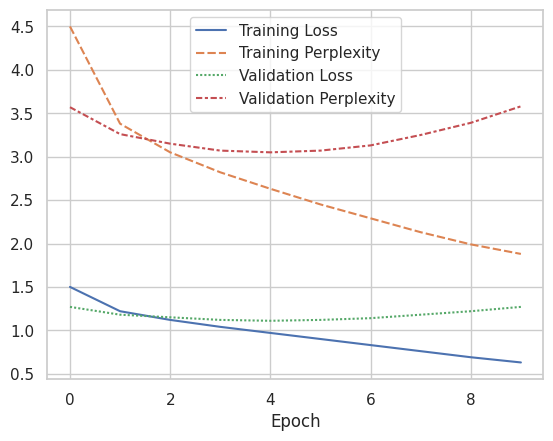

In [112]:
# plot the results from above
lp = sns.lineplot(data=train_results_df)
sns.set_style("whitegrid")
lp.set(xlabel="Epoch")

## Save the Finetuned GPT2 Model

In [110]:
save_file = "/content/drive/MyDrive/deep_learning/gpt2"
gpt2_model.save_pretrained(save_file)

# Load Models After Training

## Load RNN LSTM

### Re-initialize some parameters

In [283]:
# taken from length of rnn tokens
try: 
  print("Number of RNN Tokens:")
  print(VOCABULARY_SIZE)
except NameError:
  print("Using last known length of RNN Tokens as 176:")
  VOCABULARY_SIZE = 176
  print(VOCABULARY_SIZE)

Number of RNN Tokens:
176


In [284]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [285]:
# Directory where the checkpoints are saved.
checkpoint_dir = '/content/drive/MyDrive/deep_learning/rnn_checkpoints'

In [286]:
def build_rnn_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

### Recall RNN model from drive location

In [287]:
# reconstructed_rnn_model = tf.keras.models.load_model("/content/drive/MyDrive/deep_learning/rnn/rnn_recipe_generation")
# reconstructed_rnn_model.summary()
simplified_batch_size = 1

reconstructed_rnn_model = build_rnn_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

reconstructed_rnn_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

reconstructed_rnn_model.build(tf.TensorShape([simplified_batch_size, None]))

reconstructed_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 256)            45056     
                                                                 
 lstm_4 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_4 (Dense)             (1, None, 176)            180400    
                                                                 
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


## Load GPT2

In [73]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

In [74]:
reconstructed_gpt2_model = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/deep_learning/gpt2")

### Evaluate GPT2 Model

In [75]:
# prepare datasets for dev_list and test_list
test_dataset = GPT2Dataset(test_set, gpt2_tokenizer, max_length=768)

In [76]:
# load the datasets
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [77]:
# change device
device = torch.device("cuda")

In [78]:
def evaluate_model(model, dataloaded):
    model = model.to(device)
    model.eval()

    losses = []
    perplexity = []
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in dataloaded:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():        

            outputs  = model(b_input_ids, 
    #                            token_type_ids=None, 
                            attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]  

        batch_loss = loss.item()
        losses.append(batch_loss)
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(dataloaded)

    # Calculate perplexity.
    losses = torch.tensor(losses)
    val_perplexity = math.exp(torch.mean(losses))
    perplexity.append(val_perplexity)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation perplexity: {0:.2f}".format(val_perplexity))
    return avg_val_loss, val_perplexity

In [79]:
reconstructed_gpt2_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [80]:
print('Testing...')
test_loss, test_perplexity = evaluate_model(reconstructed_gpt2_model, test_dataloader)
test_eval_df = pd.DataFrame(columns = ["test_loss", "test_perplexity"])
test_eval_df['test_loss'] = test_loss
test_eval_df['test_perplexity'] = test_perplexity
test_eval_df.to_csv("test_eval.csv")

Testing...
  Validation Loss: 0.96
  Validation perplexity: 2.61


# Evaluate Both Models
Find a common method to evaluate both models and use the generated recipes to determine the accuracy of each model.

### Enable word wrap for printing

In [290]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Set common parameters for decoding

In [296]:
common_recipe_titles = ["Caesar Salad", "Chili", "Cinnamon Rolls", "Spaghetti Carbonara", "Chicken Alfredo", "Apple Pie", "Cheeseburger", "Lemonade"]

In [297]:
rnn_temperature = 0.1
gpt2_temperature = 0.5

### Generate Recipes from Both


#### Generate with RNN

In [298]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(rnn_tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = rnn_tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [299]:
rnn_generated_recipes = []
def generate_combinations(model):
    recipe_length = 2000

    for recipe in common_recipe_titles:
        generated_text = generate_text(
            model,
            start_string=recipe,
            num_generate = recipe_length,
            temperature = rnn_temperature
        )
        print(f'Attempt: "{recipe}" ')
        print('-----------------------------------')
        print(generated_text)
        print('\n\n')
        rnn_generated_recipes.append(generated_text)

In [300]:
rnn_generated_recipes = []
generate_combinations(reconstructed_rnn_model)

Attempt: "Caesar Salad" 
-----------------------------------
📗 Caesar Salad with Basil Salsa and Marinara sauce

📝

▪︎ Preheat oven to 350 degrees F.
▪︎ Spread some of the beer to coat and sprinkle with salt and pepper. Roast until tender, about 1 hour. Serve warm or at room temperature.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

#### Generate with GPT2

In [301]:
gpt2_generated_recipes = []
for i in range(len(common_recipe_titles[:50])):    
    input_ids = gpt2_tokenizer(common_recipe_titles[i], return_tensors='pt').input_ids
    reconstructed_gpt2_model.to(input_ids.device)
    sample_outputs = reconstructed_gpt2_model.generate(
                                        input_ids,
                                        num_beams=5, 
                                        no_repeat_ngram_size=2, 
                                        max_length = 2000,
                                        num_return_sequences=1,
                                        eos_token_id=gpt2_tokenizer.eos_token_id,
                                        pad_token_id=gpt2_tokenizer.pad_token_id,
                                        temperature = gpt2_temperature
                                    )
    gpt2_generated_recipes.append(STOP_WORD_TITLE + gpt2_tokenizer.decode(sample_outputs[0]))
    print(f'Attempt: "{common_recipe_titles[i]}" ')
    print('-----------------------------------')
    print(gpt2_generated_recipes[i])
    print('\n\n')

Attempt: "Caesar Salad" 
-----------------------------------
📗 Caesar Salad II 
🥕

 • 1 head romaine lettuce - rinsed, dried and torn into bite-size pieces 
• 2 cloves garlic, peeled and thinly sliced, or more to taste (optional) 
📝

 ▪︎ Place lettuce in a large bowl. Add garlic slices, if using. Toss with your favorite Caesar salad dressing. Serve immediately.
 ␣



Attempt: "Chili" 
-----------------------------------
📗 Chili Verde 
🥕

 • 1/2 cup extra-virgin olive oil
• 3 pounds pork butt, cut into 3/4-inch cubes, lightly oiled (see Cook's Note), or coarse salt and freshly ground black pepper 
📝

 ▪︎ Heat the oil in a large, heavy pot over medium-high heat until it shimmers. Add the pork, in batches if necessary, and cook, turning occasionally, until evenly browned, about 10 minutes. Do not lift the lid to give a peek or stir. Cook for 5 minutes, then lower the heat to maintain a gentle simmer. Continue cooking until a meat thermometer inserted into the center of a pork cube reads 1

Attempt: "Cinnamon Rolls" 
-----------------------------------
📗 Cinnamon Rolls I 
🥕

 • 2 (.25 ounce) packages active dry yeast 
• 1/2 cup warm water (110 degrees F/45 degrees C), divided - plus more if needed, plus 1 tablespoon more for thecellophane • 3/4 cup lukewarm milk (105 to 115 degrees), plus a splash for egg replacer ( processions) 
📝

 ▪︎ In a small bowl, dissolve the yeast in the water. Let stand until creamy, about 10 minutes. Lightly grease a 9x5 inch loaf pan, and add 2 tablespoons of the milk; if necessary, add a little more milk to reach the consistency of a stiff dough. Place the dough into the pan and turn to coat. Cover with a damp cloth and let rise in a warm place for about 45 minutes, or until doubled in volume. Meanwhile, preheat the oven to 450 degrees.
▎ Deflate the chilled dough and cut it into 8 equal size pieces. Roll each piece out into a 10 inch circle on a lightly floured surface to about 12 inches in diameter. The round should be buckwheat that is not 

## Compare Generated Recipes

In [314]:
def separateRecipeSections(generated_recipes_list):
  MISSING_INGREDIENTS = "No Ingredients List Generated"
  MISSING_INSTRUCTIONS = "No Instructions Generated"
  all_titles = []
  all_ingred = []
  all_instru = []

  for recipe in generated_recipes_list:
    try:
      title, recipe = recipe.split(STOP_WORD_INGREDIENTS)
      ingred = ""
    except ValueError:
      ingred = MISSING_INGREDIENTS
      try:
        title, instru = recipe.split(STOP_WORD_INSTRUCTIONS)
      except ValueError:
        instru = MISSING_INSTRUCTIONS

    
    # fill in ingredients & instructions after finding the title
    if ingred != MISSING_INGREDIENTS:
      try:
        ingred, instru = recipe.split(STOP_WORD_INSTRUCTIONS)
      except ValueError:
        instru = MISSING_INSTRUCTIONS
    
    if instru == MISSING_INSTRUCTIONS:
      try:
        blank, instru = recipe.split(" ▪︎ ")
      except:
        instru = recipe.split(" ▪︎ ")[0]
      
      


    # add it to the lists
    all_titles.append(title.strip())
    all_ingred.append(ingred.strip())
    all_instru.append(instru.strip())

  all_sections = list(zip(all_titles,all_ingred,all_instru))
  return all_sections

In [315]:
rnn_sections = separateRecipeSections(rnn_generated_recipes)
gpt2_sections = separateRecipeSections(gpt2_generated_recipes)

In [316]:
rnn_titles, rnn_ingred, rnn_instru = zip(*rnn_sections)
gpt2_titles, gpt2_ingred, gpt2_instru = zip(*gpt2_sections)


recipes_df = pd.DataFrame( {
  'Attempted Recipe Names' : common_recipe_titles,
  'RNN Title' : rnn_titles,
  'GPT2 Title' : gpt2_titles,
  'RNN Ingred' : rnn_ingred,
  'GPT2 Ingred' : gpt2_ingred,
  'RNN Instructions' : rnn_instru,
  'GPT2 Instructions' : gpt2_instru
})

display(recipes_df)

,Attempted Recipe Names,RNN Title,GPT2 Title,RNN Ingred,GPT2 Ingred,RNN Instructions,GPT2 Instructions
0,Caesar Salad,📗 Caesar Salad with Basil Salsa and Marinara s...,📗 Caesar Salad II,No Ingredients List Generated,"• 1 head romaine lettuce - rinsed, dried and t...",▪︎ Preheat oven to 350 degrees F.\n▪︎ Spread s...,▪︎ Place lettuce in a large bowl. Add garlic s...
1,Chili,📗 Chili and Chile Salad with Basil Salsa Verde...,📗 Chili Verde,No Ingredients List Generated,• 1/2 cup extra-virgin olive oil\n• 3 pounds p...,▪︎ Preheat oven to 350 degrees F.\n▪︎ Spread s...,"▪︎ Heat the oil in a large, heavy pot over med..."
2,Cinnamon Rolls,📗 Cinnamon Rolls with Cherry Tomatoes and Grap...,📗 Cinnamon Rolls I,No Ingredients List Generated,• 2 (.25 ounce) packages active dry yeast \n• ...,▪︎ Preheat oven to 350 degrees F.\n▪︎ Put pan ...,"▪︎ In a small bowl, dissolve the yeast in the ..."
3,Spaghetti Carbonara,📗 Spaghetti Carbonara Sauce with Cherry Tomato...,📗 Spaghetti Carbonara I,No Ingredients List Generated,"• 1 pound spaghetti \n• 4 eggs, lightly beaten",▪︎ Preheat oven to 350 degrees F.\n▪︎ Spread s...,▪︎ Bring a large pot of lightly salted water t...
4,Chicken Alfredo,📗 Spaghetti Carbonara Sauce with Cherry Tomato...,📗 Chicken Alfredo Sauce,No Ingredients List Generated,• 1/2 cup butter \n• 3 tablespoons all-purpose...,📗 Chicken Alfredo beans and any combination of...,▪︎ Melt butter in a saucepan over medium heat....
5,Apple Pie,📗 Apple Pie Filling (Marinated artichoke heart...,📗 Apple Pie Crust,No Ingredients List Generated,• 1 1/2 cups all-purpose flour\n• 3/4 stick (6...,▪︎ Preheat oven to 350 degrees F. Line a bakin...,▪︎ Pulse flour in a food processor until it re...
6,Cheeseburger,📗 Cheeseburger Pie Crust (See Cook's Note),📗 Cheeseburger Chowder,No Ingredients List Generated,• 1 pound ground beef \n• 2 (14.5 ounce) cans ...,▪︎ Preheat oven to 350 degrees F.\n▪︎ Spread s...,▪︎ Heat a large skillet over medium-high heat....
7,Lemonade,📗 Lemonade Compote,📗 Lemonade Pie III,No Ingredients List Generated,• 1 (9 inch) prepared graham cracker crust \n•...,▪︎ Preheat oven to 350 degrees F.\n▪︎ Stir tog...,"▪︎ In a large bowl, mix together concentrate o..."
